In [1]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def matrix_transform(mat, p):
    x = np.einsum('ij,jxy->ixy', mat[:3,:3], p)
    x += mat[:3, 3, np.newaxis, np.newaxis]
    x /= np.fmax(np.einsum('i,ixy->xy', mat[3,:3], p) + mat[3][3], 1e-6)
    return x

def process_position(position, mat):
    x = matrix_transform(mat, position)
    x = x[2:]
    x = np.clip(x, -1.0, 1.0)
    x = (x-np.mean(x)) / np.var(x)**0.5
    return x

def process_normal(normal, mat):
    # return np.einsum('ij,jxy->ixy', mat[:3,:3], normal)
    ro_s = np.array([*np.meshgrid(
        (np.arange(normal.shape[1])+0.0)/normal.shape[1],
        (np.arange(normal.shape[2])+0.0)/normal.shape[2]
    ), np.zeros(normal[0].shape)]).astype(np.float32)
    imat = np.linalg.inv(mat)
    ro = matrix_transform(imat, ro_s)
    def transform_rd(w):
        w = np.array(w)[:,np.newaxis,np.newaxis]
        r = matrix_transform(imat, ro_s+w)-ro
        r /= np.linalg.norm(r, axis=0)[np.newaxis, :, :]
        return r
    rd = transform_rd([0, 0, 1])
    ru = transform_rd([1, 0, 0])
    rv = transform_rd([0, 1, 0])
    n = np.einsum('ijxy,jxy->ixy', [ru, rv, rd], normal)
    return n


def load_data_file(filename, verbose=False):
    data = np.fromfile('data/'+filename, dtype=np.float32)
    n, w, h = map(int, filename[filename.find('_')+1:filename.find('.')].split('_'))
    mat = data[:16].reshape((4, 4))
    # mat = np.linalg.inv(mat).T
    data = data[16:].reshape((n, 3, w, h))
    position, normal, albedo = data[:3]
    normal = process_normal(normal, mat)
    depth = process_position(position, mat)
    if verbose:
        plot_frame(albedo)
        plot_frame(0.5+0.5*normal)
        plot_frame(0.5+0.5*depth)
    data = data[3:]
    n = n - 3
    ref = np.zeros((3, w, h), dtype=np.float32)
    weights = np.zeros((3, w, h), dtype=np.float32)
    for i in range(n):
        frame = data[i]
        dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**i
        ref += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
        weights += dw
        if (n-i) % 4 == 1 and verbose:
            print(2**i, 'spp')
            plot_frame(frame**(1.0/2.2))
    ref /= np.fmax(weights, 1)
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        # x = np.clip(x, 0.0, 1.0)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2
    if verbose:
        print("converged")
        plot_frame(ref**(1.0/2.2))
    aux = np.concatenate((albedo, normal, depth)).astype(np.float32)
    aux = np.nan_to_num(aux, nan=0.0, posinf=1.0, neginf=-1.0)
    return {
        'w': w,
        'h': h,
        'aux': aux,
        'data': data,
        'ref': ref
    }


torch.Size([8, 3, 256, 256])


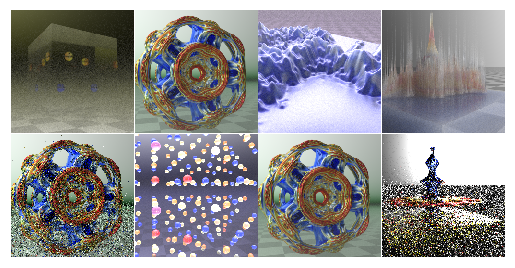

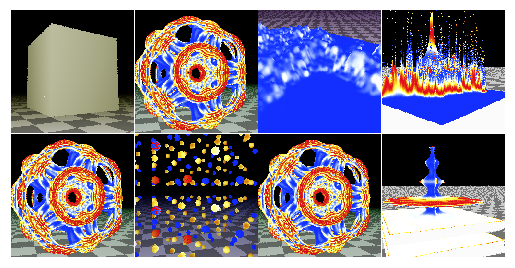

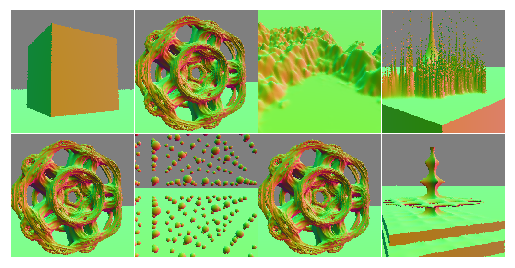

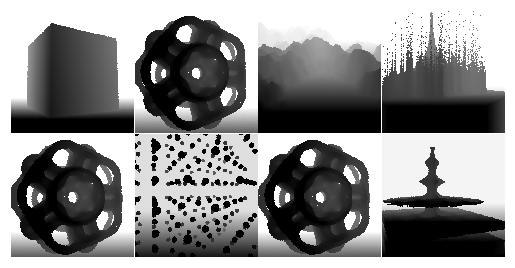

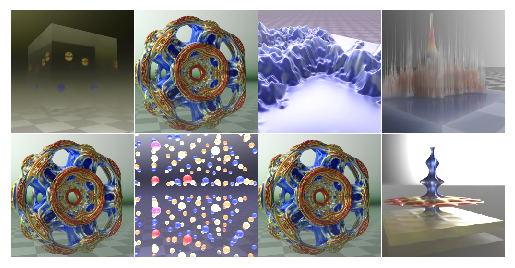

In [3]:
class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = [load_data_file(filename) for filename in os.listdir("data/")]
        s = 256
        self.n = n
        self.s = s
        self.coords = []
        for i in range(n):
            k = np.random.randint(0, len(self.data))
            x = np.random.randint(0, self.data[k]['w']-s+1)
            y = np.random.randint(0, self.data[k]['h']-s+1)
            self.coords.append((k, x, y))

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        k, x, y = self.coords[i]
        s = self.s
        n = self.data[k]['data'].shape[0]
        total = np.zeros((3, s, s), dtype=np.float32)
        weights = np.zeros((3, s, s), dtype=np.float32)
        spp = round(0.6 * np.random.random()**4 * 2**n + 0.5)
        for _ in range(n):
            if (spp >> _) & 1 == 0:
                continue
            frame = self.data[k]['data'][_, :, x:x+s, y:y+s]
            dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**_
            total += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
            weights += dw
        return [
            np.fmax(total / np.fmax(weights, 1), 0.0) ** (1.0/2.2),
            self.data[k]['aux'][:, x:x+s, y:y+s],
            np.fmax(self.data[k]['ref'][:, x:x+s, y:y+s], 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, a, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(a[:, 0:3])
plot_imgs(a[:, 3:6]*0.5+0.5)
plot_imgs(a[:, 6:7]*0.5+0.5)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True, padding_mode='reflect')

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True, padding_mode='reflect')

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def relu(x):
    return F.relu(x, inplace=False)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n0 = 16
        n1 = 24
        n2 = 32
        n3 = 48
        n4 = 64
        # self.econv0 = conv3(10, n0) # 1
        self.econv0a = conv3(10, n0) # 1
        self.econv0b = conv3(n0, n0) # 1
        self.econv1 = conv3(n0, n1) # 1/2
        self.econv2 = conv3(n1, n2) # 1/4
        self.econv3 = conv3(n2, n3) # 1/8
        self.mconv1 = conv3(n3, n4) # 1/16
        self.mconv2 = conv3(n4, n4) # 1/16
        self.dconv3a = dconv4(n4, n3) # 1/16->1/8
        self.dconv3b = conv3(n3+n3, n3) # 1/8
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.dconv2b = conv3(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.dconv1b = conv3(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        # self.dconv0b = conv3(n0+n0, 3) # 1
        self.dconv0b = conv3(n0+n0, n0) # 1
        self.dconv0 = conv3(n0, 3) # 1

    def forward(self, input):
        # e0 = self.econv0(input) # 1
        e0 = self.econv0b(relu(self.econv0a(input))) # 1
        e1 = self.econv1(pool(e0)) # 1/2
        e2 = self.econv2(pool(e1)) # 1/4
        e3 = self.econv3(pool(e2)) # 1/8
        m1 = self.mconv1(pool(e3)) # 1/16
        m2 = self.mconv2(relu(m1)) # 1/16
        d3 = relu(self.dconv3a(relu(m2))) # 1/8
        d3 = relu(self.dconv3b(concat(d3, e3))) # 1/8
        d2 = relu(self.dconv2a(d3)) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = relu(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = relu(self.dconv0a(d1)) # 1
        d0 = relu(self.dconv0b(concat(d0, e0))) # 1
        # return d0
        # return d0 + input[:, :3]
        return self.dconv0(d0)


model = Model().to(device)
print(model)

Model(
  (econv0a): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (econv0b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (econv1): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (econv2): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (econv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (mconv1): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (mconv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (dconv3a): ConvTranspose2d(64, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv3b): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (dconv2a): ConvTranspose2d(48, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv2b): C

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
)
256 0.04910280928015709
512 0.05603288114070892
768 0.03546278551220894
1024 0.04273071885108948
1280 0.04269895702600479
1536 0.053908683359622955
1792 0.03864938020706177
2048 0.0529564768075943
2304 0.017557892948389053
2560 0.041918713599443436
2816 0.027787528932094574
3072 0.0315810926258564
3328 0.05538599565625191
3584 0.035201311111450195
3840 0.02449023723602295
4096 0.018758554011583328
4352 0.020961929112672806
4608 0.02789471670985222
4864 0.03400062397122383
5120 0.025935759767889977
5376 0.03129727393388748
5632 0.03346242010593414
5888 0.022946152836084366
6144 0.02993059903383255
6400 0.02526896446943283
6656 0.02573326975107193
6912 0.028245950117707253
7168 0.02486373297870159
7424 0.031373005360364914
7680 0.03396903723478317
7936 0.02506088651716709
8192 0.0

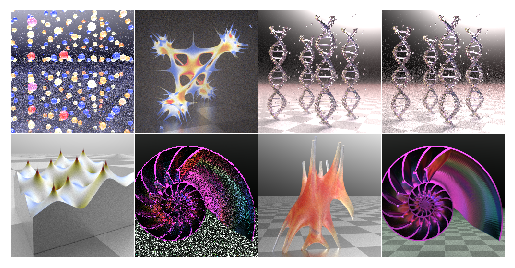

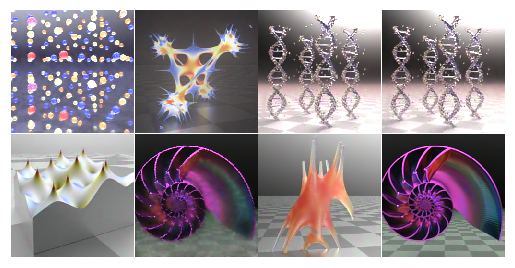

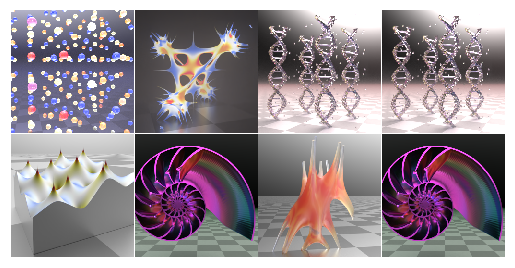

8448 0.019906826317310333
8704 0.018133623525500298
8960 0.024825960397720337
9216 0.013317905366420746
9472 0.013497119769454002
9728 0.031832367181777954
9984 0.01572989672422409
10240 0.02576340362429619
10496 0.02915666066110134
10752 0.016514167189598083
11008 0.018924526870250702
11264 0.022194217890501022
11520 0.01374586671590805
11776 0.018430422991514206
12032 0.022082529962062836
12288 0.02040865272283554
12544 0.022112030535936356
12800 0.01971915178000927
13056 0.020182549953460693
13312 0.02899543195962906
13568 0.019870154559612274
13824 0.019807107746601105
14080 0.022419452667236328
14336 0.03454960882663727
14592 0.035185590386390686
14848 0.014335396699607372
15104 0.018022820353507996
15360 0.018826618790626526
15616 0.02202567830681801
15872 0.014353964477777481
16128 0.014632364735007286
16384 0.022114507853984833


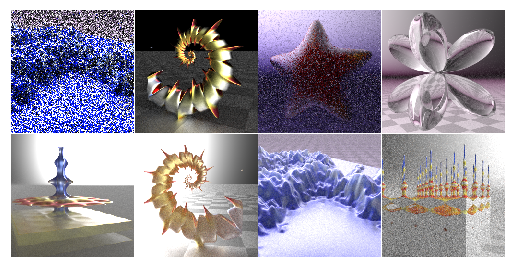

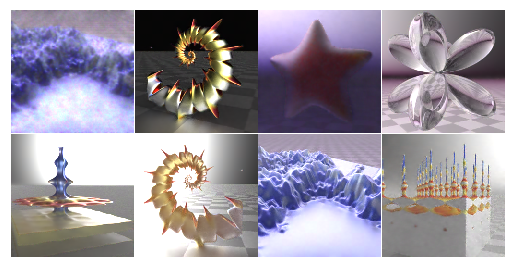

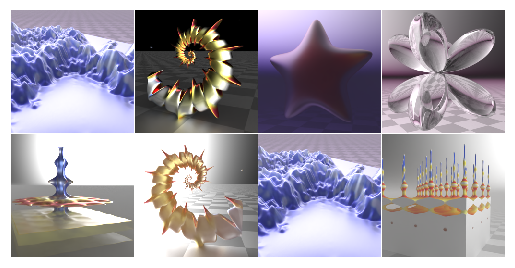

16640 0.025075802579522133
16896 0.022175544872879982
17152 0.0243392214179039
17408 0.027279194444417953
17664 0.028205631300807
17920 0.01515200361609459
18176 0.024150041863322258
18432 0.020477021113038063
18688 0.0200098417699337
18944 0.015410971827805042
19200 0.027697663754224777
19456 0.020810484886169434
19712 0.014679936692118645
19968 0.021842733025550842
20224 0.027757927775382996
20480 0.016029685735702515
20736 0.03663951903581619
20992 0.01612069644033909
21248 0.0333038792014122
21504 0.02353861555457115
21760 0.01976776123046875
22016 0.016498863697052002
22272 0.023262687027454376
22528 0.031139198690652847
22784 0.01579749584197998
23040 0.013997483998537064
23296 0.010250727646052837
23552 0.017215989530086517
23808 0.01414413470774889
24064 0.020831666886806488
24320 0.030101247131824493
24576 0.015874803066253662


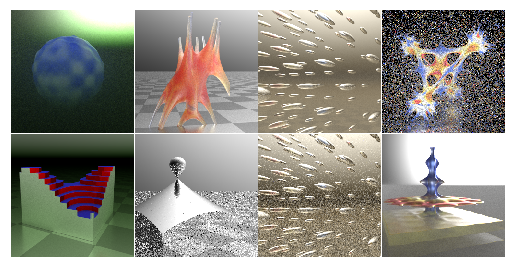

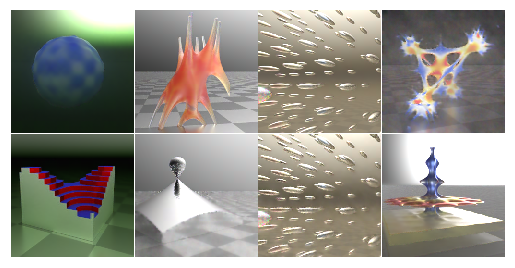

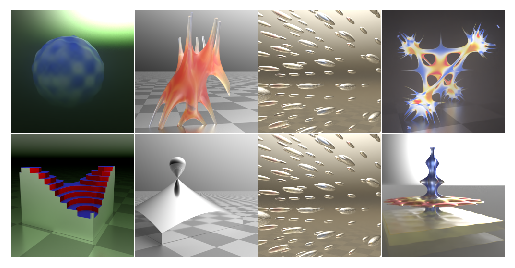

24832 0.018955662846565247
25088 0.02098274789750576
25344 0.012300891801714897
25600 0.008530693128705025
25856 0.0310222040861845
26112 0.01841557025909424
26368 0.026628397405147552
26624 0.01485417503863573
26880 0.016743242740631104
27136 0.017938515171408653
27392 0.019474098458886147
27648 0.0279197059571743
27904 0.017568092793226242
28160 0.019290052354335785
28416 0.021830137819051743
28672 0.020300332456827164
28928 0.026168478652834892
29184 0.021737050265073776
29440 0.03179623931646347
29696 0.020642073825001717
29952 0.01511811651289463
30208 0.019779246300458908
30464 0.02409593015909195
30720 0.017734892666339874
30976 0.02361389435827732
31232 0.012423777021467686
31488 0.027253758162260056
31744 0.016155991703271866
32000 0.01551358588039875
32256 0.015621693804860115
32512 0.025360707193613052
32768 0.017187142744660378


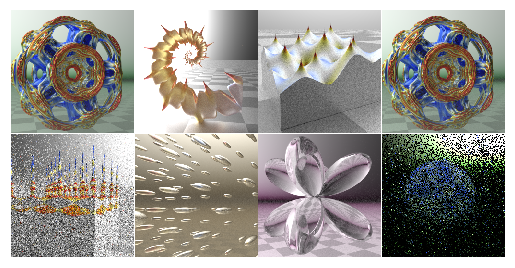

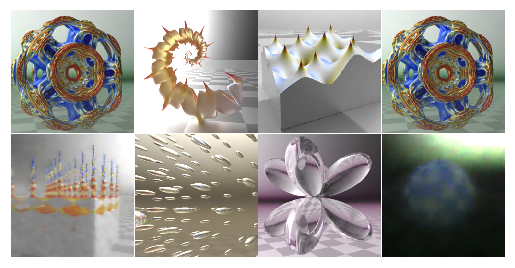

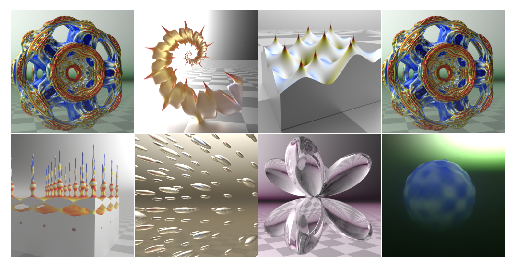

33024 0.008356322534382343
33280 0.016183871775865555
33536 0.0228247232735157
33792 0.007111238781362772
34048 0.017151782289147377
34304 0.02099783718585968
34560 0.016490276902914047
34816 0.013106409460306168
35072 0.019535817205905914
35328 0.024236073717474937
35584 0.01399243250489235
35840 0.01220298744738102
36096 0.016088014468550682
36352 0.013794464990496635
36608 0.018095234408974648
36864 0.022319724783301353
37120 0.019614573568105698
37376 0.02573447674512863
37632 0.0256133284419775
37888 0.05584640055894852
38144 0.03246342018246651
38400 0.02256222814321518
38656 0.02797013893723488
38912 0.02611490711569786
39168 0.036559008061885834
39424 0.019900526851415634
39680 0.0347973071038723
39936 0.034256819635629654
40192 0.011776961386203766
40448 0.01731584593653679
40704 0.022325532510876656
40960 0.02259635552763939


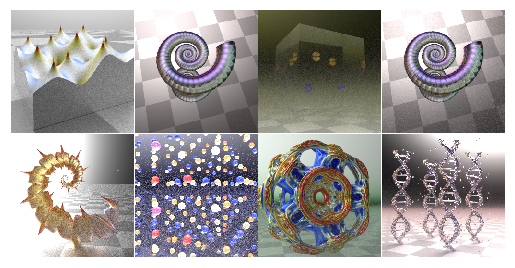

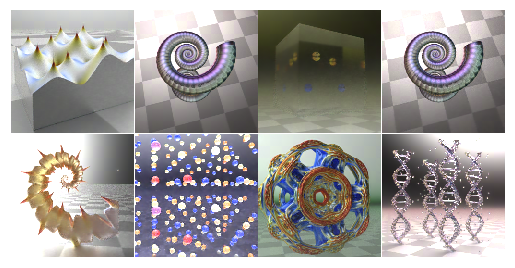

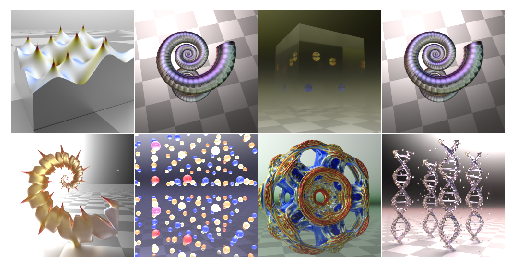

41216 0.012271931394934654
41472 0.02500838041305542
41728 0.018236983567476273
41984 0.011552585288882256
42240 0.018473422154784203
42496 0.013064892962574959
42752 0.01446398627012968
43008 0.017241861671209335
43264 0.02475927397608757
43520 0.0113744605332613
43776 0.024804463610053062
44032 0.023323118686676025
44288 0.021577147766947746
44544 0.017797527834773064
44800 0.02697041444480419
45056 0.01509703230112791
45312 0.023072607815265656
45568 0.01122664101421833
45824 0.022697357460856438
46080 0.030055945739150047
46336 0.027665704488754272
46592 0.02301875874400139
46848 0.02875465899705887
47104 0.02703663893043995
47360 0.014583533629775047
47616 0.020015716552734375
47872 0.021320316940546036
48128 0.016830405220389366
48384 0.025928709656000137
48640 0.018744440749287605
48896 0.016735035926103592
49152 0.014774489216506481


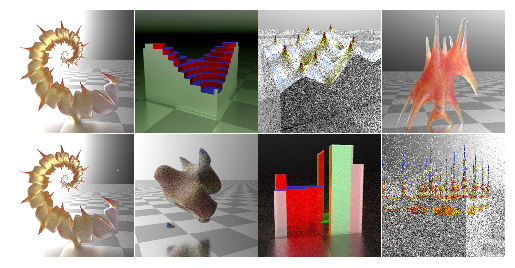

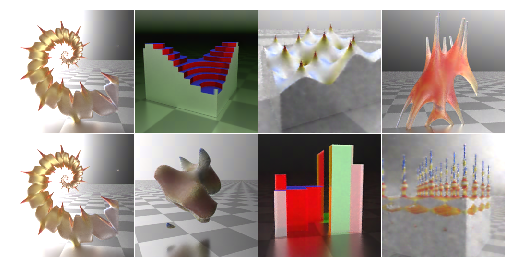

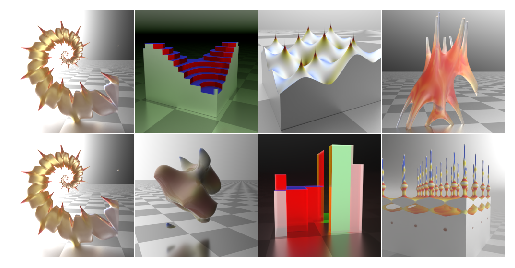

49408 0.02701810747385025
49664 0.026084331795573235
49920 0.020632687956094742
50176 0.018707893788814545
50432 0.017973318696022034
50688 0.018304716795682907
50944 0.02406441420316696
51200 0.02883080765604973
51456 0.03469683974981308
51712 0.015684952959418297
51968 0.02362043410539627
52224 0.019431136548519135
52480 0.01993531547486782
52736 0.02382764033973217
52992 0.011457683518528938
53248 0.011857561767101288
53504 0.03042953461408615
53760 0.023782838135957718
54016 0.015154167078435421
54272 0.01609499566257
54528 0.02608899027109146
54784 0.06300795823335648
55040 0.07578375935554504
55296 0.06851817667484283
55552 0.05420215427875519
55808 0.04686736315488815
56064 0.036682285368442535
56320 0.04278187081217766
56576 0.04259043186903
56832 0.05101639777421951
57088 0.037393245846033096
57344 0.032818906009197235


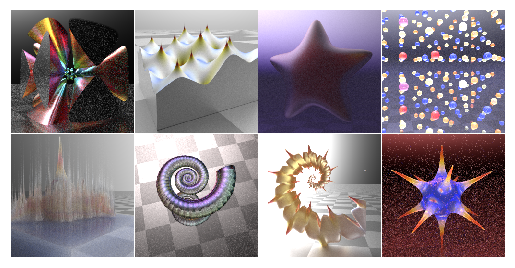

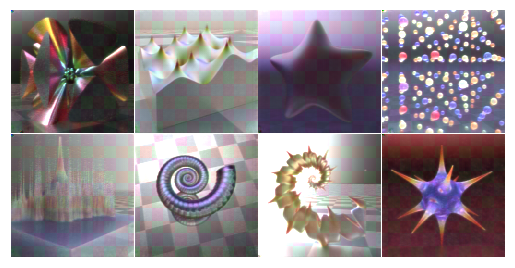

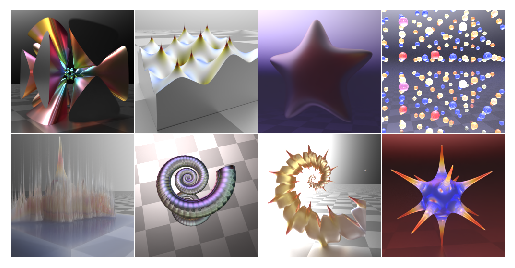

57600 0.03972296416759491
57856 0.026517869904637337
58112 0.02564527839422226
58368 0.024683784693479538
58624 0.04562902823090553
58880 0.034818097949028015
59136 0.025920655578374863
59392 0.03533802554011345
59648 0.02534019760787487
59904 0.023220030590891838
60160 0.0282580628991127
60416 0.022540898993611336
60672 0.0364767462015152
60928 0.03404174745082855
61184 0.025165066123008728
61440 0.022492140531539917
61696 0.017708510160446167
61952 0.03173098340630531
62208 0.014502367004752159
62464 0.03262028098106384
62720 0.017515039071440697
62976 0.032398950308561325
63232 0.01822270080447197
63488 0.02276826836168766
63744 0.02973146364092827
64000 0.022585667669773102
64256 0.025890018790960312
64512 0.01283201389014721
64768 0.01483081839978695
65024 0.02396392822265625
65280 0.03378252685070038
65536 0.03427150100469589


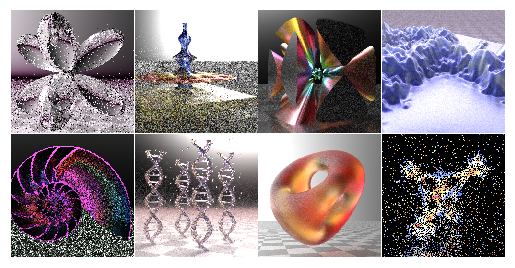

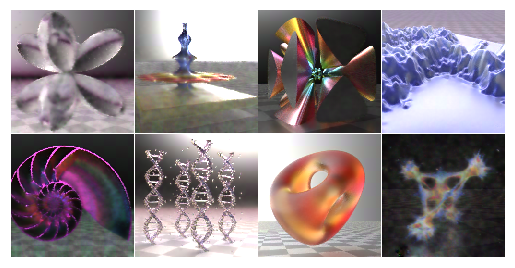

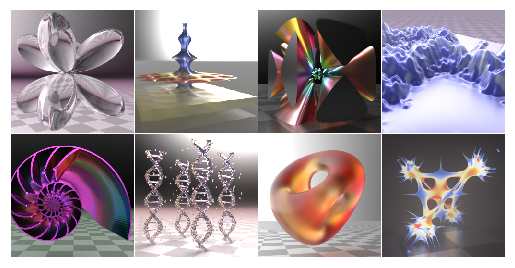

In [5]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001
    # lr = 0.00001
)

import torchvision.models
vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
vgg16_features = vgg16.features
vgg16_head = vgg16_features[:4].to(device)
print(vgg16_head)

def lossfun(output, reference, input):
    # r1 = torch.mean(torch.abs(output-reference))
    r2 = torch.mean(torch.abs(vgg16_head(output)-vgg16_head(reference)))
    return r2
    # return 0.5*r1 + 0.5*r2

model_params = torch.cat([x.view(-1) for x in model.parameters()])

batch_count = 0
for epoch in range(4):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**17), batch_size=8, shuffle=True)
    for x, a, y in trainloader:
        x = x.to(device)
        a = a.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)
        optimizer.zero_grad()
        m_in = torch.concatenate((x, a), axis=1)
        output = model(m_in)
        loss = lossfun(output, y, x)
        regularize = 0.2 * torch.mean(torch.abs(model_params))
        (loss+regularize).backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 256 == 0:
            print(batch_count, loss.item())
        if batch_count % 8192 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp(output.detach())-1)
            plot_imgs(torch.exp(y)-1)


In [6]:
torch.save(model, "model2r.pth")